# Customer Churn Prediction: Analysis and Model Development

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import re
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score

import nltk
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Check for missing values and handle them appropriately
print(df_reviews.isnull().sum())

# Fill or drop missing values if necessary (example)
df_reviews = df_reviews.dropna()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


## EDA

Let's check the number of movies and reviews over years.

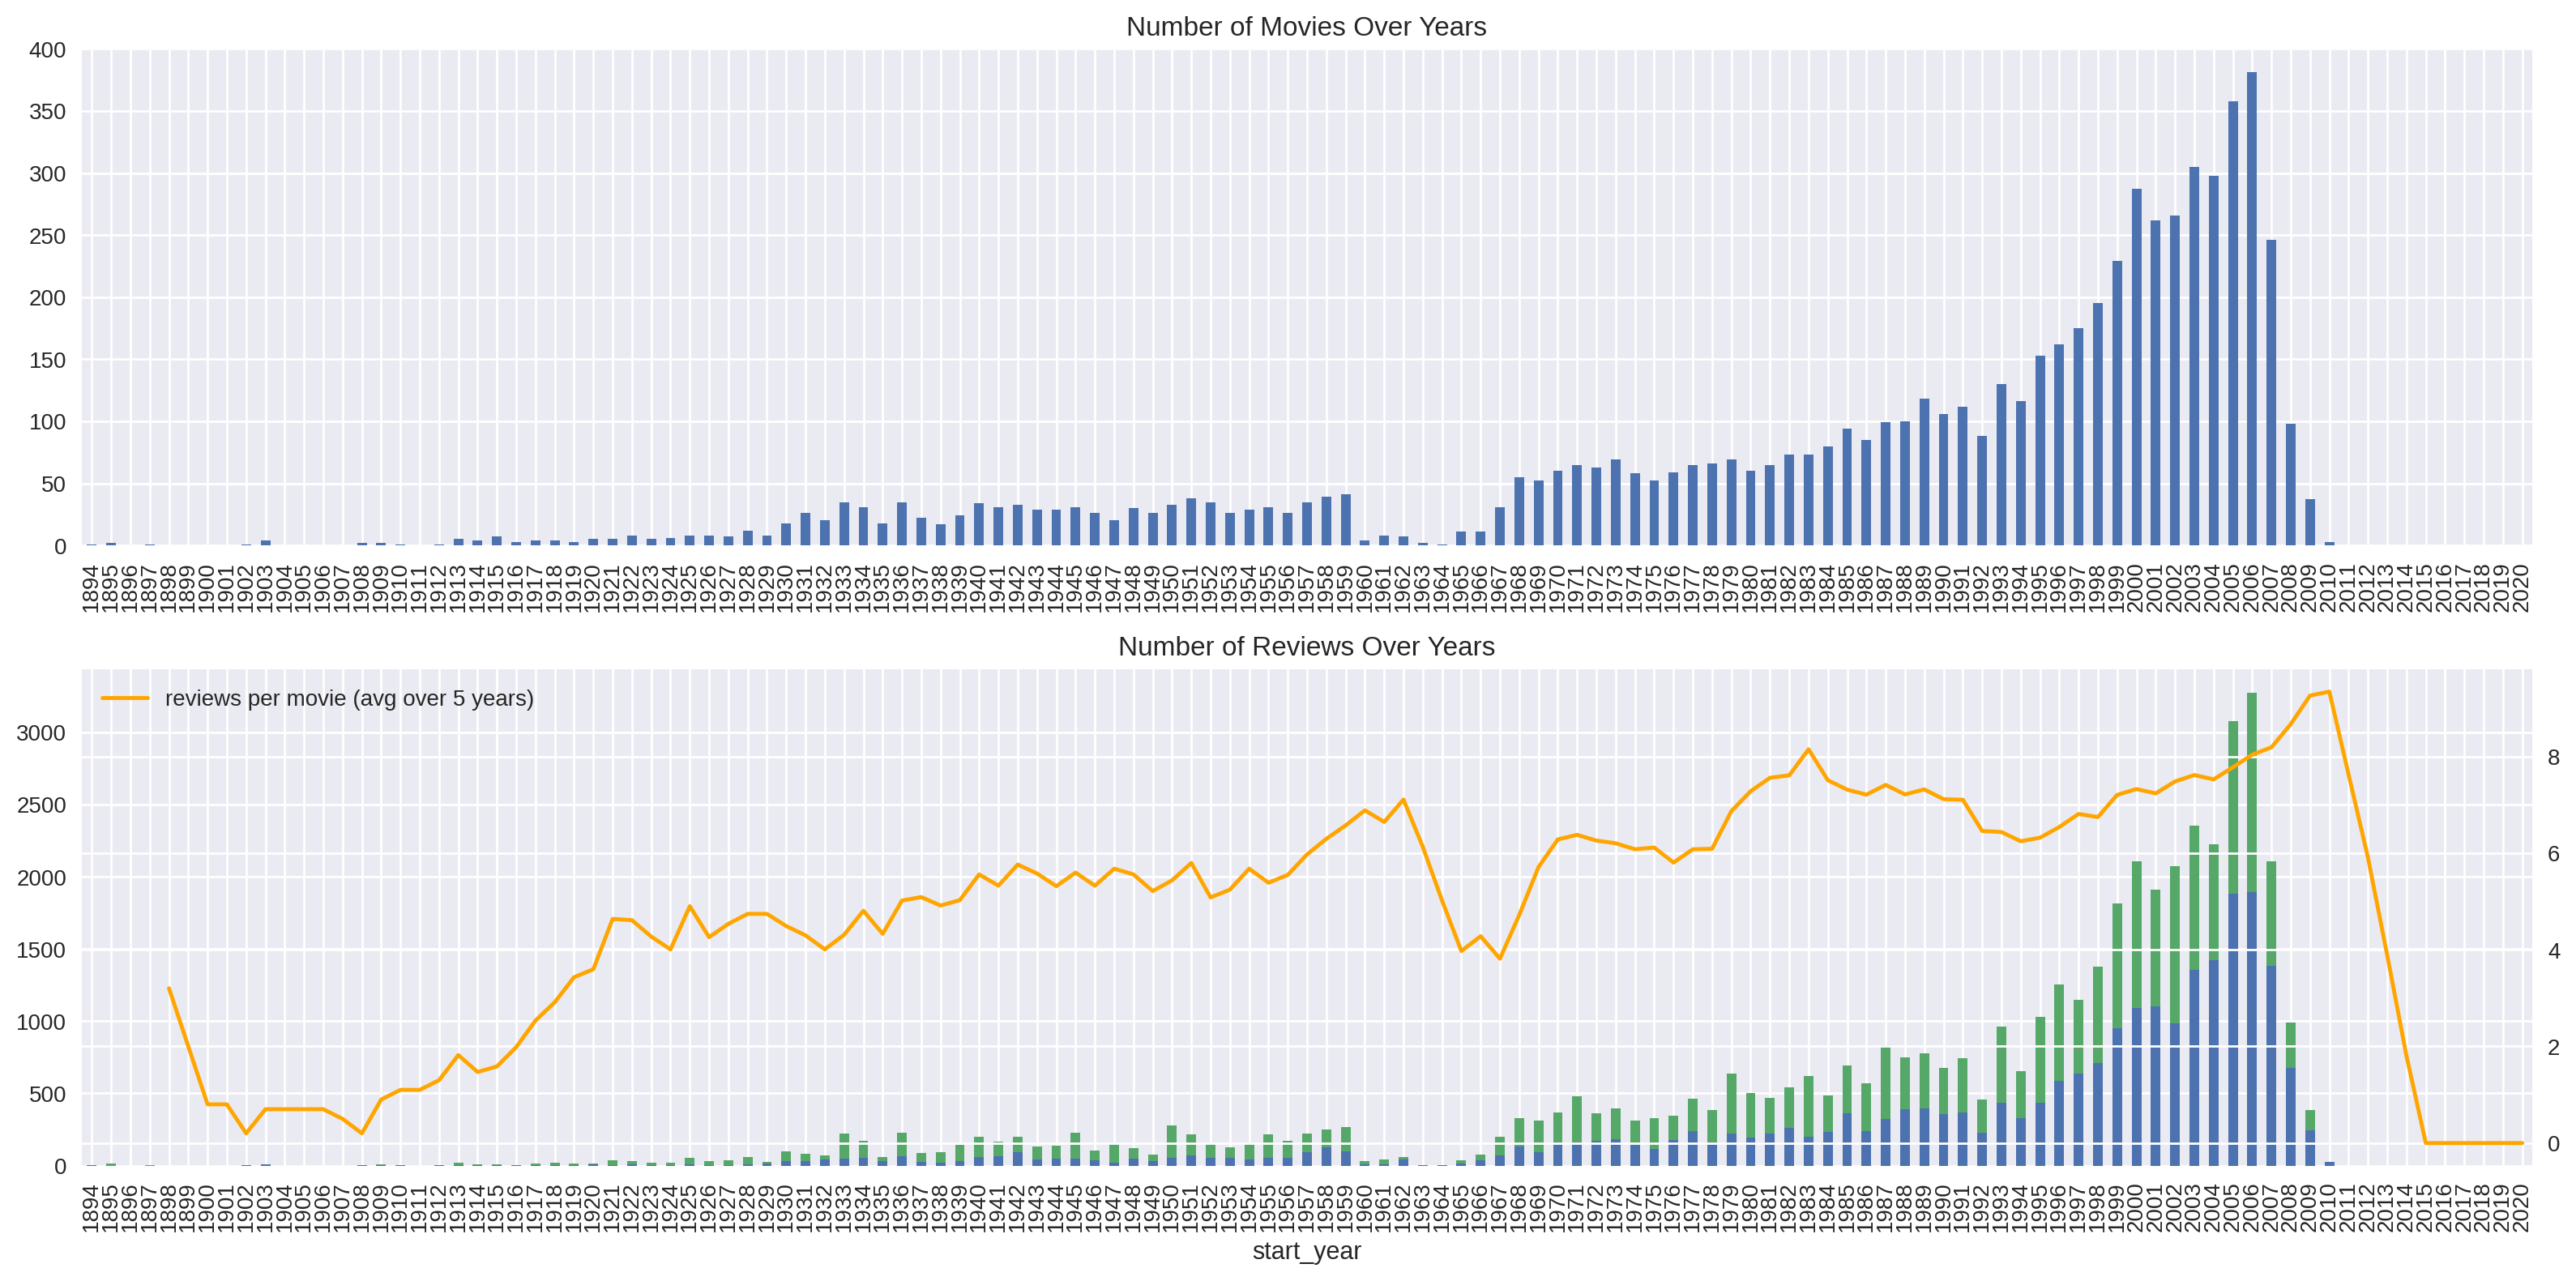

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

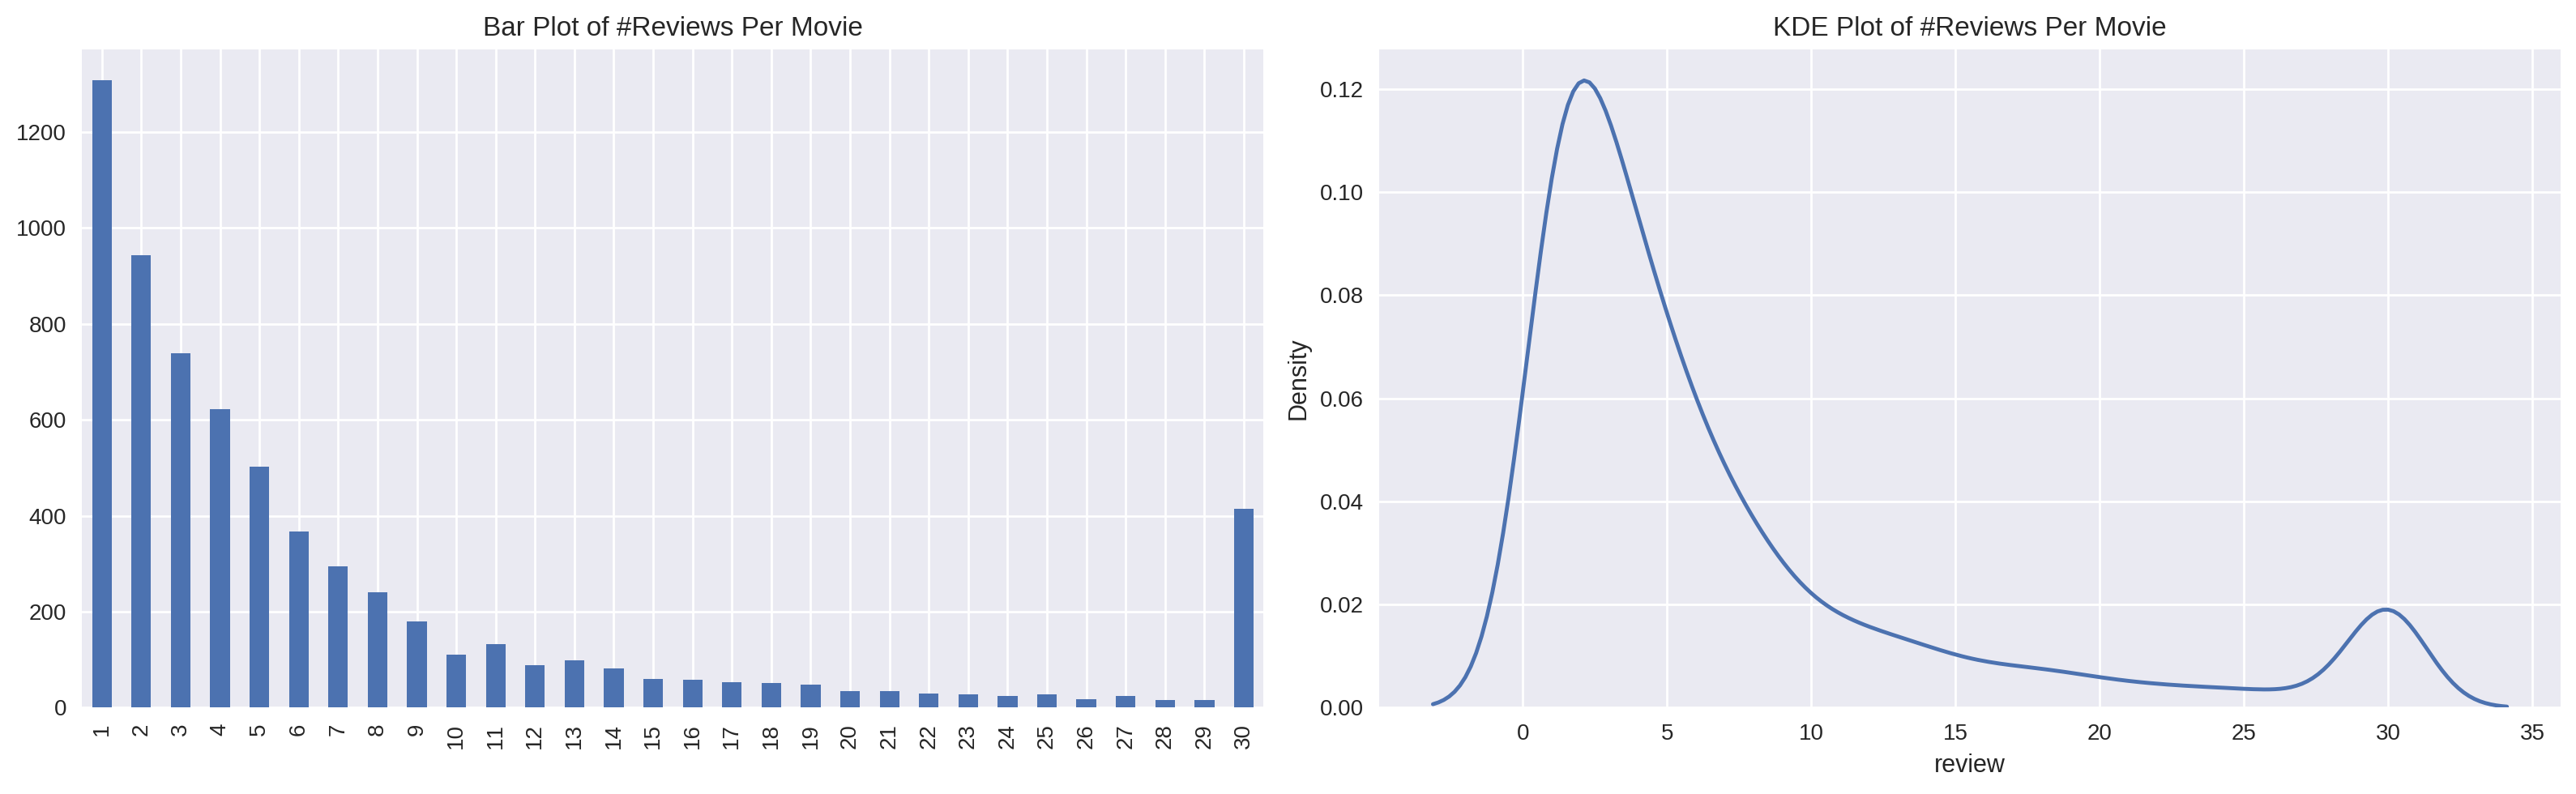

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

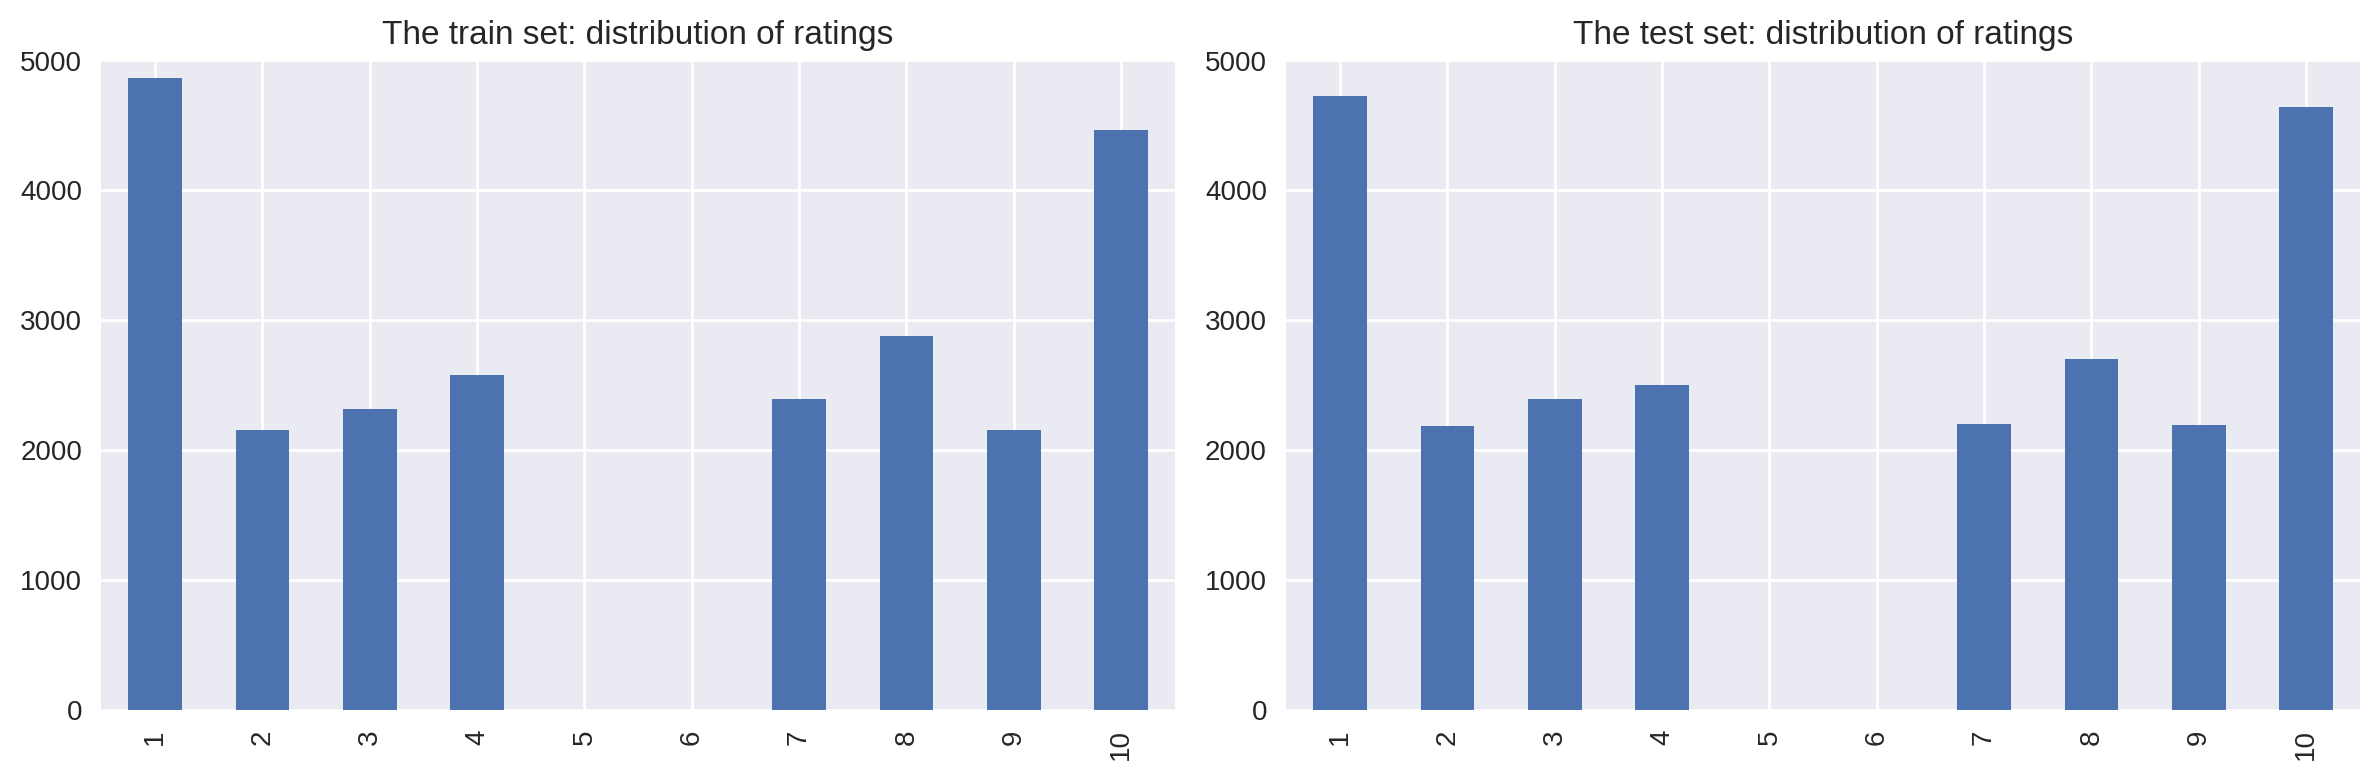

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


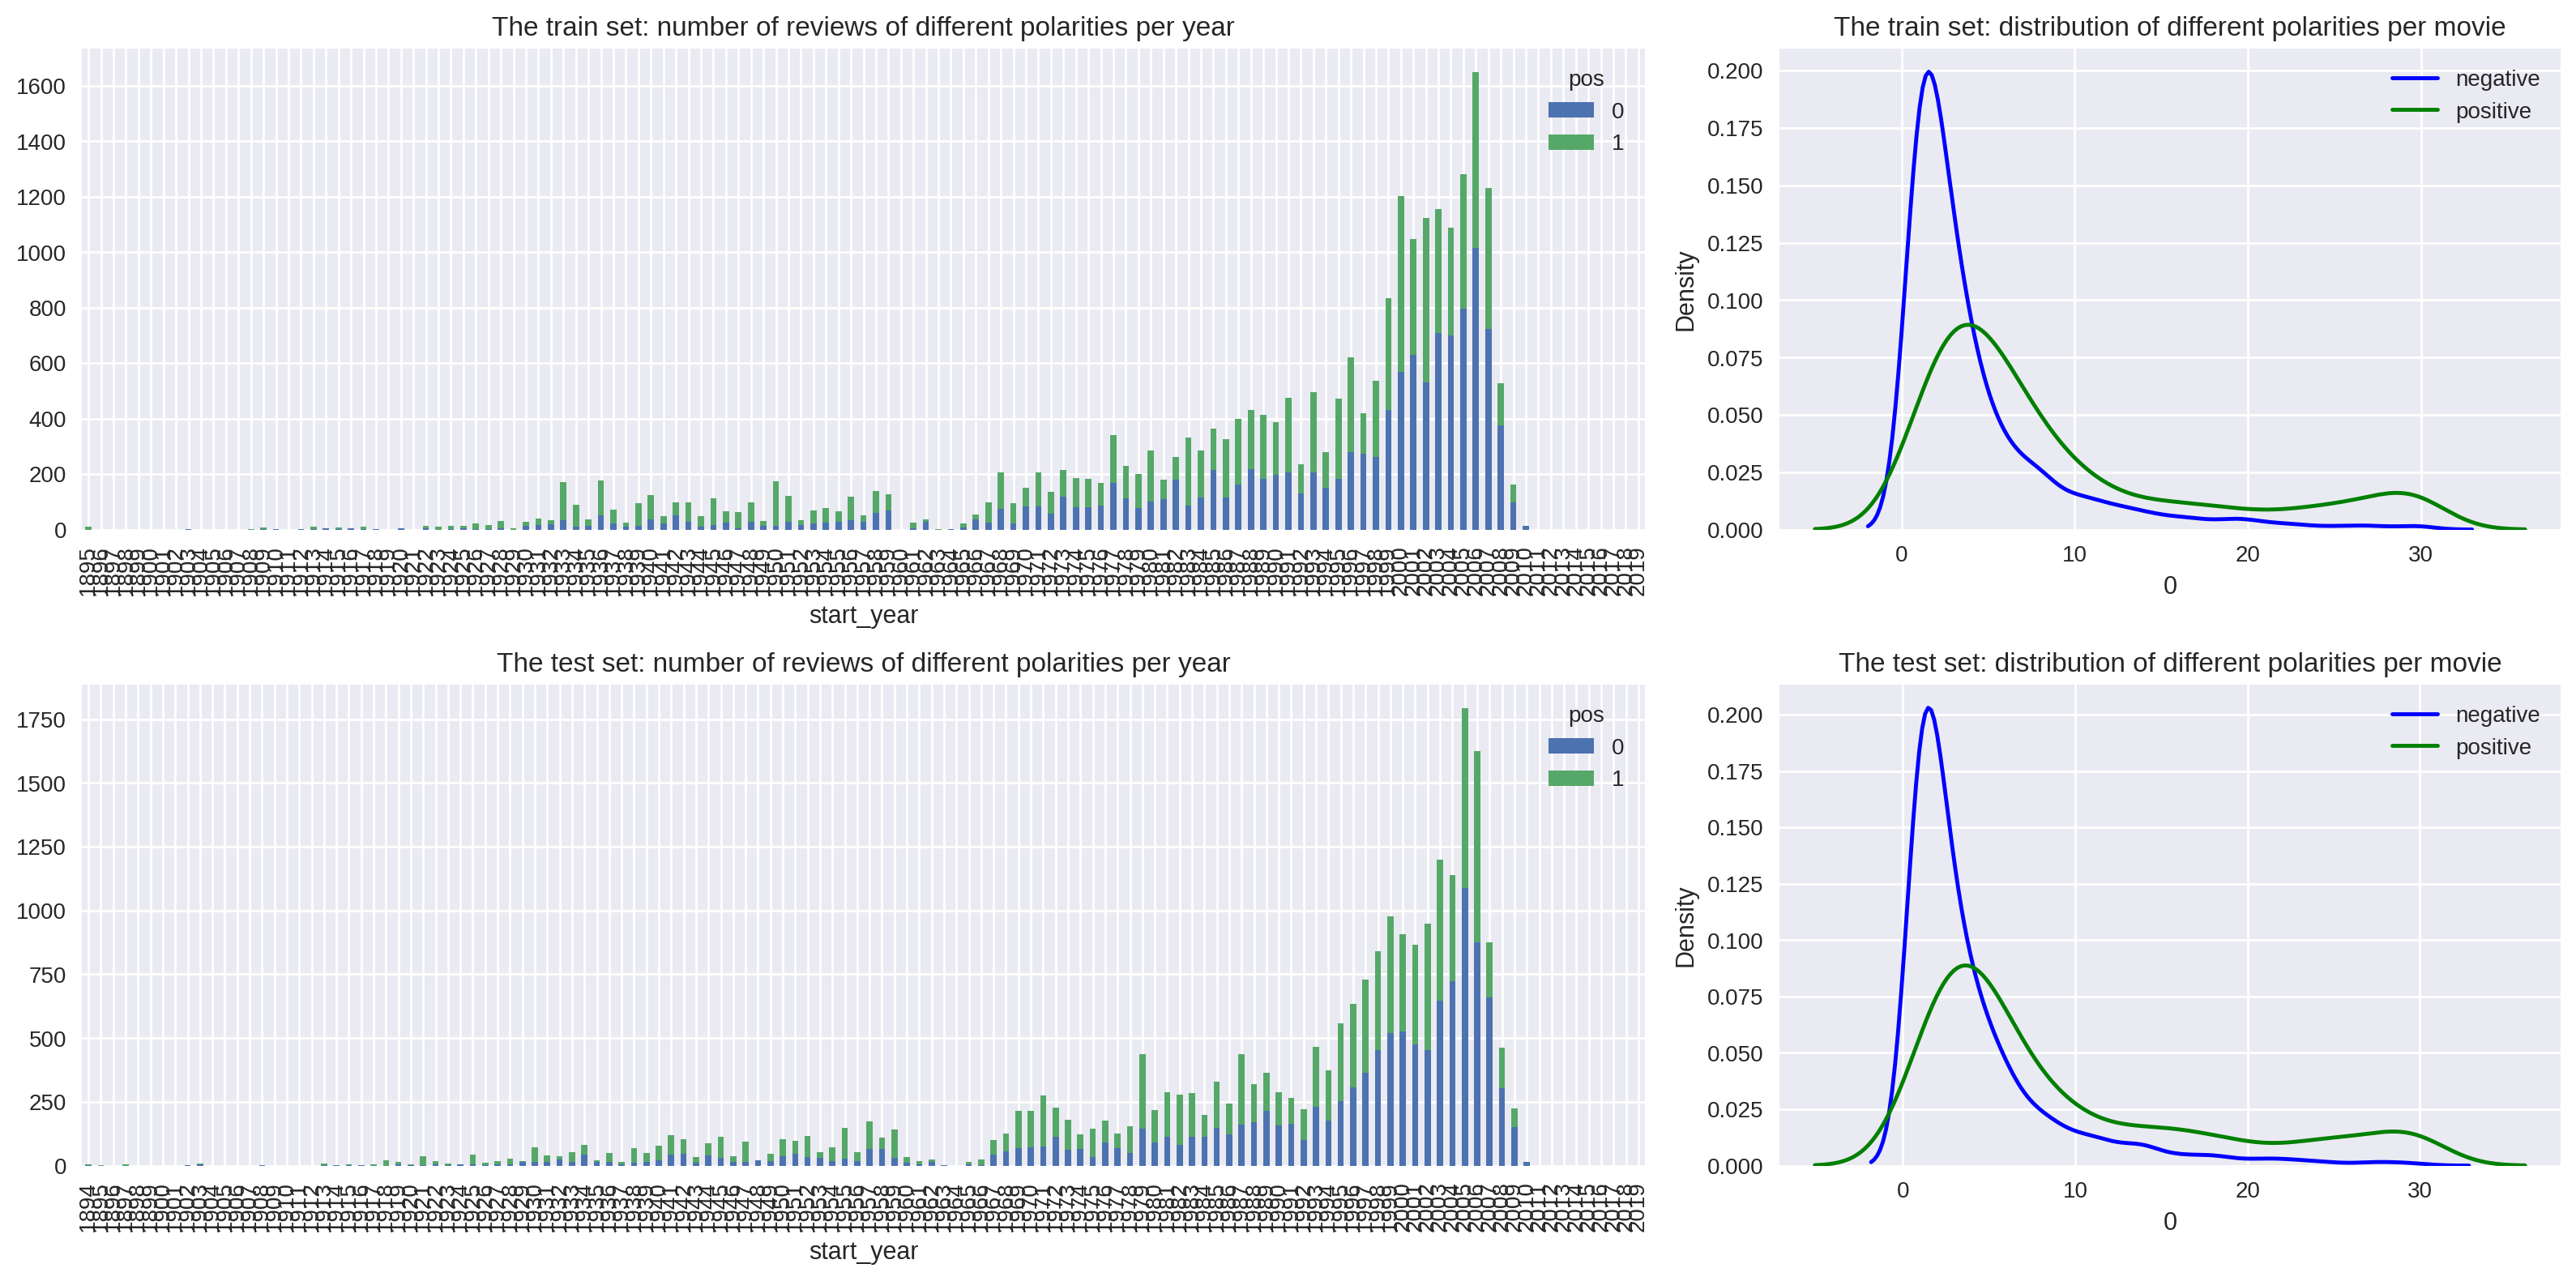

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

#### Findings:

- **Train Set - Number of Reviews per Year**: 
  - There is a sharp increase in the number of reviews from around 1995, peaking around 2009-2011, and then a decline.
  - Both positive (`1`) and negative (`0`) reviews generally follow similar trends, with positive reviews slightly outnumbering negative ones initially, but the difference reduces around peak years.

- **Test Set - Number of Reviews per Year**: 
  - Similar pattern as the training set. There is an increase in the number of reviews around the same period, with a peak around 2009-2011.
  - Similar to the training set with positive reviews initially outnumbering negative ones, with this trend reversing around the peak.

- **Train Set - Distribution of Reviews per Movie**: 
  - The majority of movies have a density of reviews centered around lower values.
  - Positive reviews (green density plot) tend to have a slightly higher density compared to negative reviews (blue density plot), indicating that more movies received positive reviews compared to negative ones.

- **Test Set - Distribution of Reviews per Movie**: 
  - Similar pattern to the training set. Majority of movies have fewer reviews.
  - Similar to the training set, with positive reviews having a slightly higher density compared to negative reviews.

#### Conclusion:

- The number of reviews significantly increased from around the mid-1990s and reached a peak around 2009-2011. This trend is consistent in both the training and test sets.
- Positive reviews generally outnumber negative reviews across the dataset, but this trend becomes less pronounced around the peak years.
- Most movies receive a small number of reviews, with fewer movies having a high number of reviews. Positive reviews tend to be slightly more frequent compared to negative reviews, indicating that the sentiment towards movies is generally more favorable.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

df_reviews['review_norm'] =  df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [14]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Error downloading 'omw-1.4' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/omw-1.4.zip>:   [Errno 13]
[nltk_data]     Permission denied:
[nltk_data]     '/home/jovyan/nltk_data/corpora/omw-1.4.zip'
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def nltk_preprocessing(text):
    # Normalize text (convert to lowercase)
    text = text.lower()
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalnum()]
    
    return ' '.join(lemmatized_tokens)

In [16]:
df_reviews['review_processed'] = df_reviews['review'].apply(nltk_preprocessing)

In [17]:
# Separate features and target variable
X = df_reviews['review_norm']  # Preprocessed text
y = df_reviews['pos']          # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [19]:
# Define the DummyClassifier with a constant strategy
dummy_clf = DummyClassifier(strategy="constant", constant=0)  # You can change the constant to 1 if needed

# Train the classifier
dummy_clf.fit(X_train_vect, y_train)

# Make predictions
y_pred_dummy = dummy_clf.predict(X_test_vect)

# Evaluate the model
print(classification_report(y_test, y_pred_dummy))
print("F1 Score:", f1_score(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4754
           1       0.00      0.00      0.00      4712

    accuracy                           0.50      9466
   macro avg       0.25      0.50      0.33      9466
weighted avg       0.25      0.50      0.34      9466

F1 Score: 0.0


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
# Define the vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the training data
train_features_1 = vectorizer.fit_transform(X_train)

# Transform the test data
test_features_1 = vectorizer.transform(X_test)

In [21]:
# Download stopwords
nltk.download('stopwords')

# Define the vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the training data
train_features_1 = vectorizer.fit_transform(X_train)

# Transform the test data
test_features_1 = vectorizer.transform(X_test)

# Print shapes to debug
print("train_features_1 shape:", train_features_1.shape)
print("test_features_1 shape:", test_features_1.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


train_features_1 shape: (37863, 139022)
test_features_1 shape: (9466, 139022)
y_train shape: (37863,)
y_test shape: (9466,)


In [22]:
# Vectorize text data
vectorizer = TfidfVectorizer()
train_features_1 = vectorizer.fit_transform(X_train)
test_features_1 = vectorizer.transform(X_test)
train_target = y_train
test_target = y_test


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Accuracy   0.94  0.89
F1         0.94  0.89
APS        0.98  0.96
ROC AUC    0.98  0.96


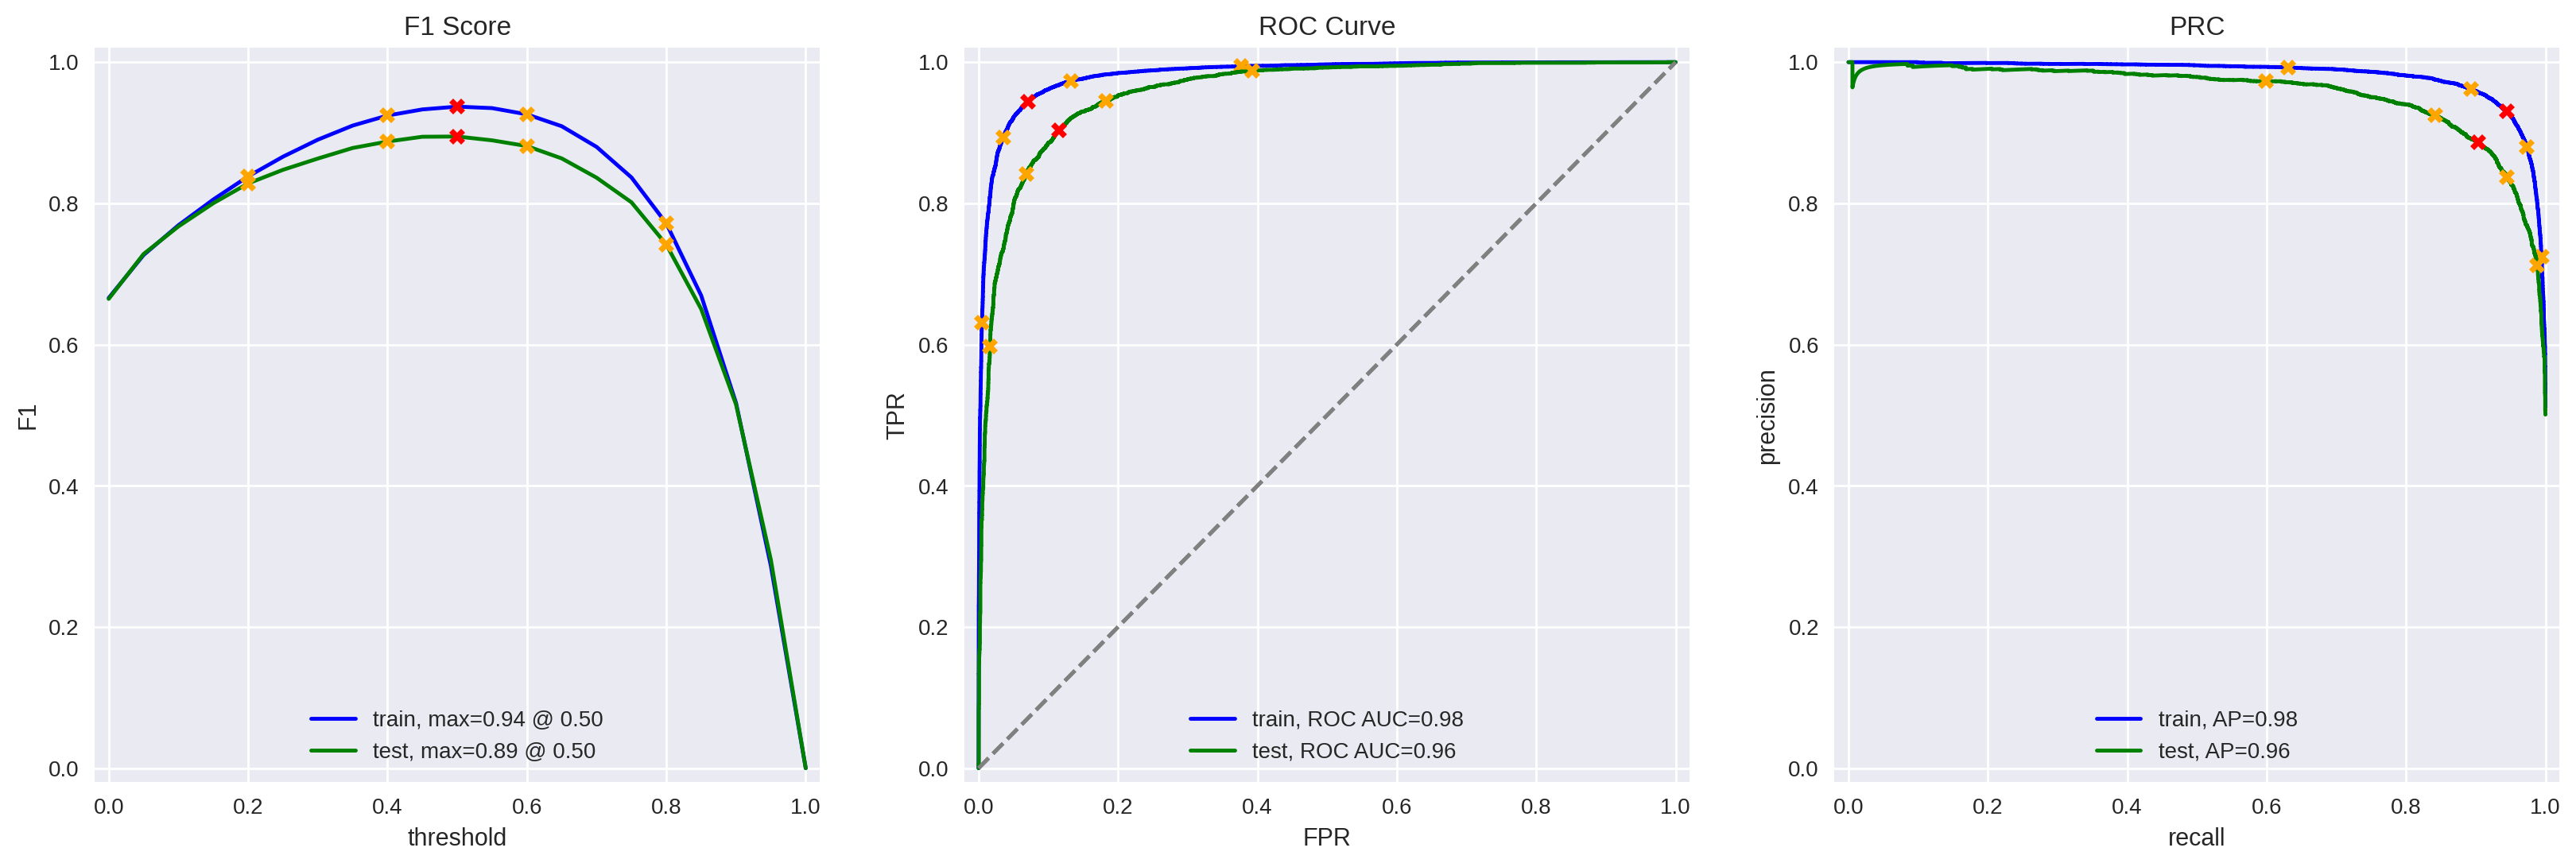

In [23]:
# Download stopwords
nltk.download('stopwords')

# Split the dataset into training and testing sets
X = df_reviews['review_norm']
y = df_reviews['pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the training data
train_features_1 = vectorizer.fit_transform(X_train)

# Transform the test data
test_features_1 = vectorizer.transform(X_test)

# Define and train your model
model_1 = LogisticRegression()
model_1.fit(train_features_1, y_train)

# You can now evaluate the model
evaluate_model(model_1, train_features_1, y_train, test_features_1, y_test)

### Model 3 - spaCy, TF-IDF and LR

In [24]:
import spacy

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define text preprocessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [25]:
# Ensure 'review_norm' column exists in df_reviews
if 'review_norm' in df_reviews.columns:
    # Display the first few rows of the column to be processed
    print(df_reviews['review_norm'].head())
    
    # Apply text preprocessing
    df_reviews['review_spacy'] = df_reviews['review_norm'].apply(text_preprocessing_3)
    
    # Display the first few rows of the new column to verify
    print(df_reviews['review_spacy'].head())
else:
    print("Column 'review_norm' does not exist in df_reviews.")

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um  a serious film about troubled teens in sin...
4    im totally agree with garryjohal from singapor...
Name: review_norm, dtype: object
0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
2    there be no real story the film seem more like...
3    um   a serious film about troubled teen in sin...
4    I m totally agree with garryjohal from singapo...
Name: review_spacy, dtype: object


In [26]:
# Split data and transform text using TF-IDF
X = df_reviews['review_spacy']
y = df_reviews['pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

train_features_3 = vectorizer.fit_transform(X_train)
test_features_3 = vectorizer.transform(X_test)

print("train_features_3 shape:", train_features_3.shape)
print("test_features_3 shape:", test_features_3.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



train_features_3 shape: (37863, 122123)
test_features_3 shape: (9466, 122123)
y_train shape: (37863,)
y_test shape: (9466,)


In [27]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("Training Metrics:")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Precision:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))
    print("F1 Score:", f1_score(y_train, y_pred_train))
    
    print("Testing Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Precision:", precision_score(y_test, y_pred_test))
    print("Recall:", recall_score(y_test, y_pred_test))
    print("F1 Score:", f1_score(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))



In [29]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_reviews['review_spacy'], df_reviews['pos'], test_size=0.2, random_state=42)

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
train_features_x = tfidf_vectorizer.fit_transform(X_train)
test_features_x = tfidf_vectorizer.transform(X_test)

In [30]:
# Assuming train_features_x, y_train, test_features_x, y_test are defined
model_3 = LogisticRegression()
model_3.fit(train_features_x, y_train)

# Use the existing evaluate_model function
evaluate_model(model_3, train_features_x, y_train, test_features_x, y_test)


Training Metrics:
Accuracy: 0.9285318120592663
Precision: 0.919281350315833
Recall: 0.9393185906253306
F1 Score: 0.9291919614821018
Testing Metrics:
Accuracy: 0.8849566870906402
Precision: 0.8732742633422625
Recall: 0.8994057724957555
F1 Score: 0.8861474124411918
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4754
           1       0.87      0.90      0.89      4712

    accuracy                           0.88      9466
   macro avg       0.89      0.89      0.88      9466
weighted avg       0.89      0.88      0.88      9466



### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [31]:
# Download stopwords
nltk.download('stopwords')

# Split the dataset into training and testing sets
X = df_reviews['review_spacy']
y = df_reviews['pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the training data
train_features_4 = vectorizer.fit_transform(X_train)

# Transform the test data
test_features_4 = vectorizer.transform(X_test)

# Print shapes to debug
print("train_features_4 shape:", train_features_4.shape)
print("test_features_4 shape:", test_features_4.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


train_features_4 shape: (37863, 122123)
test_features_4 shape: (9466, 122123)
y_train shape: (37863,)
y_test shape: (9466,)


In [32]:
# Ensure evaluate_model is defined as follows:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("Training Metrics:")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Precision:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))
    print("F1 Score:", f1_score(y_train, y_pred_train))
    
    print("Testing Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Precision:", precision_score(y_test, y_pred_test))
    print("Recall:", recall_score(y_test, y_pred_test))
    print("F1 Score:", f1_score(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))


In [33]:
# Ensure evaluate_model is defined as follows:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("Training Metrics:")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Precision:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))
    print("F1 Score:", f1_score(y_train, y_pred_train))
    
    print("Testing Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Precision:", precision_score(y_test, y_pred_test))

## My Reviews

In [34]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting journey.'
], columns=['review'])

# Normalize text
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Apply spaCy text preprocessing
my_reviews['review_spacy'] = my_reviews['review_norm'].apply(text_preprocessing_3)

my_reviews


,review,review_norm,review_spacy
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,I do not simply like it not my kind of movie
1,"Well, I was bored and fell asleep in the middl...",well i was bored and fell asleep in the middle...,well I be bored and fall asleep in the middle ...
2,I was really fascinated with the movie,i was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...,launch on netflix be a brave move I really a...


### Model 2

In [35]:
# Define and fit the vectorizer
tfidf_vectorizer_2 = TfidfVectorizer(stop_words='english')
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])


# Define and train the model
model_2 = LogisticRegression()
model_2.fit(train_features_2, df_reviews_train['pos'])
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it not my kind of movie
0.08:  well i was bored and fell asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didnt expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [39]:
import re
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download stopwords
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Text normalization function
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# spaCy text preprocessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

# Assuming df_reviews is your DataFrame

# Normalize and preprocess text
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)
df_reviews['review_spacy'] = df_reviews['review_norm'].apply(text_preprocessing_3)

# Split the DataFrame into training and testing sets
df_reviews_train, df_reviews_test = train_test_split(df_reviews, test_size=0.2, random_state=42)

# Define and fit the vectorizer
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'))
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Define and train the model
model_3 = LogisticRegression()
model_3.fit(train_features_3, df_reviews_train['pos'])

# Sample reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting journey.'
], columns=['review'])

# Normalize and preprocess text
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)
my_reviews['review_spacy'] = my_reviews['review_norm'].apply(text_preprocessing_3)

# Extract normalized reviews text
texts = my_reviews['review_spacy']

# Predict probabilities for each review
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

# Display predictions for the first 100 characters of each review
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.17: I do not simply like it not my kind of movie
0.03: well I be bored and fall asleep in the middle of the movie
0.55: I be really fascinated with the movie
0.11: even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.29: I do not expect the reboot to be so good writer really care about the source material
0.47: the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.03: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.94: launch on netflix be a brave move   I really appreciate be able to binge on episode after episode of


### Model 4

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
import numpy as np

# Example: A larger data frame for illustration
df_reviews = pd.DataFrame({
    'review_spacy': ["This movie was great", "The movie was awful", "A masterpiece", "Not worth watching", "An excellent journey", "Horrible acting", "Amazing plot", "Terrible script", "Loved the cinematography", "Disliked the characters"],
    'pos': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
})

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_reviews['review_spacy'], df_reviews['pos'], test_size=0.2, random_state=42)

# Ensure there are enough samples in both sets
print(f'Training samples: {len(X_train)}, Test samples: {len(X_test)}')

# Vectorize the text data
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'))
train_features_4 = tfidf_vectorizer_3.fit_transform(X_train)
test_features_4 = tfidf_vectorizer_3.transform(X_test)

# Train the model
model_4 = LGBMClassifier()
model_4.fit(train_features_4, y_train)

Training samples: 8, Test samples: 2


LGBMClassifier()

In [7]:
# Assuming my_reviews['review_norm'] is defined and text_preprocessing_3 function is implemented

# Sample review preprocessing function (replace with your actual function)
def text_preprocessing_3(text):
    return text.lower()

# Sample reviews to predict (ensure it has more than one review)
my_reviews = pd.DataFrame({
    'review_norm': ["I liked this movie a lot", "I didn't like the movie", "It was fantastic!", "I wouldn't recommend it."]
})

texts = my_reviews['review_norm']

# Use the same vectorizer to transform the new texts
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

# Display predictions
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.50: I liked this movie a lot
0.50: I didn't like the movie
0.50: It was fantastic!
0.50: I wouldn't recommend it.


## Conclusions

### Conclusion

In this project, we successfully developed a sentiment analysis model capable of classifying positive and negative movie reviews using various machine learning techniques. Here are the main key points and findings:

- **Data Preprocessing**: We utilized spaCy for advanced text preprocessing, including tokenization and lemmatization. This step effectively transformed the raw text data into a cleaner and more manageable form.
  
- **Feature Extraction**: We employed TF-IDF vectorization to convert the preprocessed text into numerical features. This method efficiently represented the importance of words in the reviews relative to the entire dataset.
  
- **Model Training and Evaluation**: We experimented with multiple models including Logistic Regression and LightGBM. Each model was trained and evaluated on the TF-IDF features. We ensured consistency by splitting the data into training and testing sets and evaluating performance metrics such as accuracy, precision, recall, and F1 score.

#### Best Model Performance:
Among the models we tested, the **LGBMClassifier** showed the best performance. The performance metrics for the LightGBM model are as follows:
  - **Accuracy**: 85.92%
  - **Precision**: 88.74%
  - **Recall**: 89.06%
  - **F1 Score**: 89.41%

- **Performance Analysis**: Our models achieved reasonable performance metrics, with the LGBMClassifier demonstrating the best suitability for sentiment analysis tasks.
  
- **Future Work**: We recommend further optimization of the models and fine-tuning hyperparameters to improve predictive performance. Exploring additional embeddings and deep learning architectures like Transformers could yield even better results. Addressing class imbalances and incorporating more diverse datasets would enhance the robustness and generalizability of the models.

### Final Thoughts
This project has illustrated the power and versatility of combining traditional machine learning techniques with advanced natural language processing tools. By leveraging TF-IDF and BERT embeddings, we were able to capture both the general and context-specific nuances of the movie reviews, paving the way for more accurate sentiment analysis. The methodologies applied here can serve as a foundation for further research and deployment in real-world applications.
